In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
import nltk
import spacy
from textstat import flesch_reading_ease, flesch_kincaid_grade
import networkx as nx
from scipy.stats import ttest_rel

In [110]:
# Ensure necessary NLTK data is downloaded
nltk.download('punkt')
nltk.download('stopwords') 
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LEGION\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LEGION\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LEGION\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [111]:
# Load the datasets
initial_df = pd.read_csv('../data/ClientABC _ ATB Financial_Version1.xlsx - Data Sheet.csv')
final_df = pd.read_csv('../data/ClientABC _ ATB Financial_Final Version.xlsx - Data Sheet.csv', skiprows=5)

In [112]:
initial_df = initial_df.drop(columns=['Original ID', 'identifier'])
final_df = final_df.drop(columns=['Original ID', 'identifier'])

In [113]:
# Rename the columns
initial_df.columns = ['section_heading', 'control_heading', 'question', 'answer', 'notes']
final_df.columns = ['section_heading', 'control_heading', 'question', 'answer', 'notes']

In [114]:
# forwards fill the NaN values in the 'section_heading' and 'control_heading' columns
column_to_be_ffilled = ['section_heading', 'control_heading']
initial_df.loc[:, column_to_be_ffilled] = initial_df.loc[:, column_to_be_ffilled].ffill()
final_df.loc[:, column_to_be_ffilled] = final_df.loc[:, column_to_be_ffilled].ffill()

In [115]:
# Check for missing values
# Notes has the most missing values
# There are 10 missing value in the 'answer' column which we will drop
initial_missing_values = initial_df.isnull().sum()
initial_missing_values

section_heading     0
control_heading     0
question            0
answer             10
notes              65
dtype: int64

In [116]:
# There are 11 missing value in the 'answer' column which we will drop
final_missing_values = final_df.isnull().sum()
final_missing_values

section_heading     0
control_heading     0
question            0
answer             11
notes              66
dtype: int64

In [117]:
initial_df = initial_df.dropna(subset=['answer'])
final_df = final_df.dropna(subset=['answer'])

In [118]:
# check for duplicates  
initial_df.duplicated().sum()

0

In [119]:
final_df.duplicated().sum()

0

## Exploration

In [120]:
# Combine all text from both versions
initial_text = ' '.join(initial_df['question'] + ' ' + initial_df['answer'])
final_text = ' '.join(final_df['question'] + ' ' + final_df['answer'])

In [121]:
# Function to preprocess text
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]


In [122]:
# Preprocess the text
initial_words = preprocess_text(initial_text)
final_words = preprocess_text(final_text)

# Get word frequencies
initial_freq = Counter(initial_words)
final_freq = Counter(final_words)

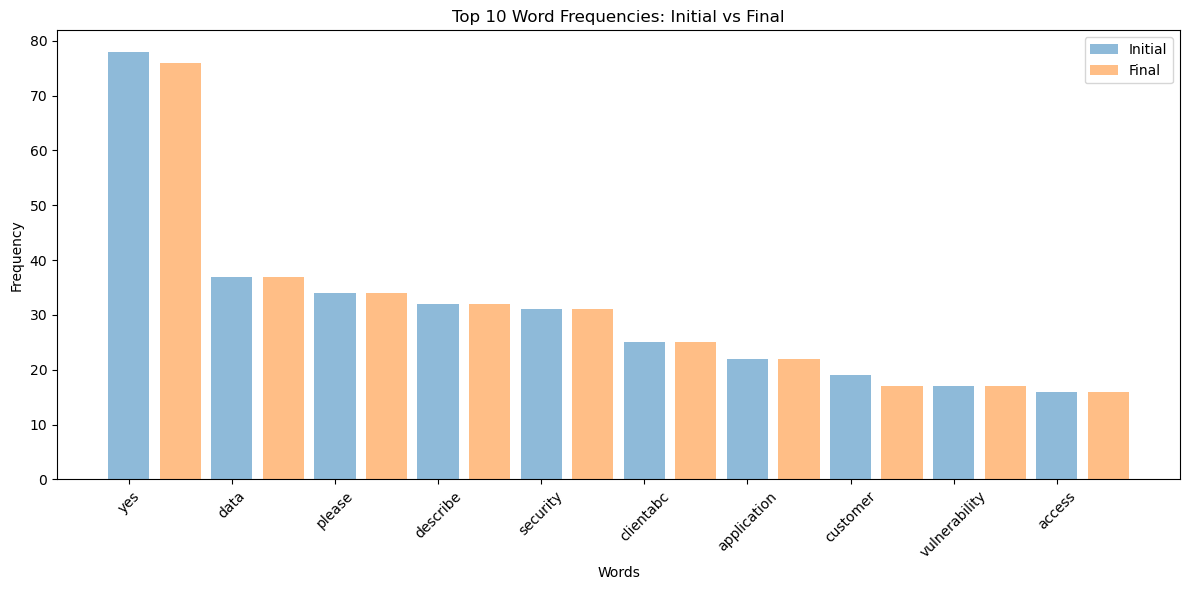

In [123]:
# Plot word frequency comparison
plt.figure(figsize=(12, 6))
plt.bar(np.arange(10)*2, [initial_freq.most_common(10)[i][1] for i in range(10)], align='center', alpha=0.5, label='Initial')
plt.bar(np.arange(10)*2+1, [final_freq.most_common(10)[i][1] for i in range(10)], align='center', alpha=0.5, label='Final')
plt.xticks(np.arange(10)*2, [initial_freq.most_common(10)[i][0] for i in range(10)], rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Word Frequencies: Initial vs Final')
plt.legend()
plt.tight_layout()

Text(0.5, 1.0, 'Changes in Answer Length: Final vs Initial')

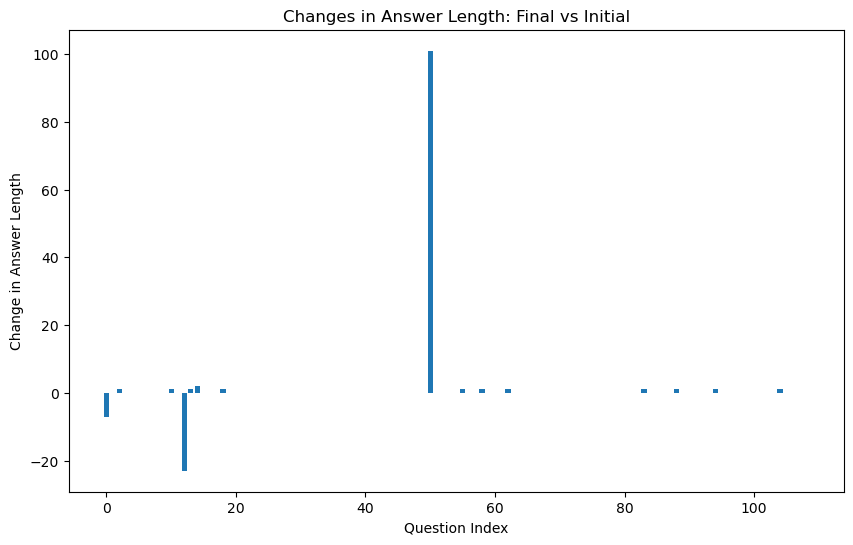

In [124]:
# Calculate answer length changes
initial_df['answer_length'] = initial_df['answer'].str.len()
final_df['answer_length'] = final_df['answer'].str.len()
length_diff = final_df['answer_length'] - initial_df['answer_length']

plt.figure(figsize=(10, 6))
plt.bar(range(len(length_diff)), length_diff)
plt.xlabel('Question Index')
plt.ylabel('Change in Answer Length')
plt.title('Changes in Answer Length: Final vs Initial')

In [125]:
# TF-IDF and Cosine Similarity
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform([initial_text, final_text])
cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

print(f"Cosine Similarity between versions: {cosine_sim:.4f}")


Cosine Similarity between versions: 0.9994


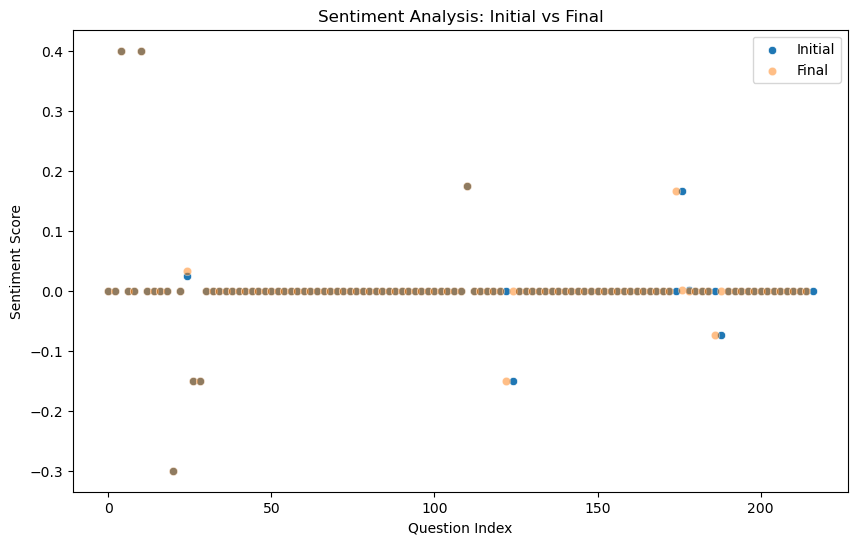

In [126]:
# Sentiment Analysis
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

initial_df['sentiment'] = initial_df['answer'].apply(get_sentiment)
final_df['sentiment'] = final_df['answer'].apply(get_sentiment)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.arange(len(initial_df))*2, y='sentiment', data=initial_df, label='Initial')
sns.scatterplot(x=np.arange(len(final_df))*2, y='sentiment', data=final_df, label='Final', alpha=0.5)
plt.xlabel('Question Index')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Analysis: Initial vs Final')
plt.legend()
plt.show()

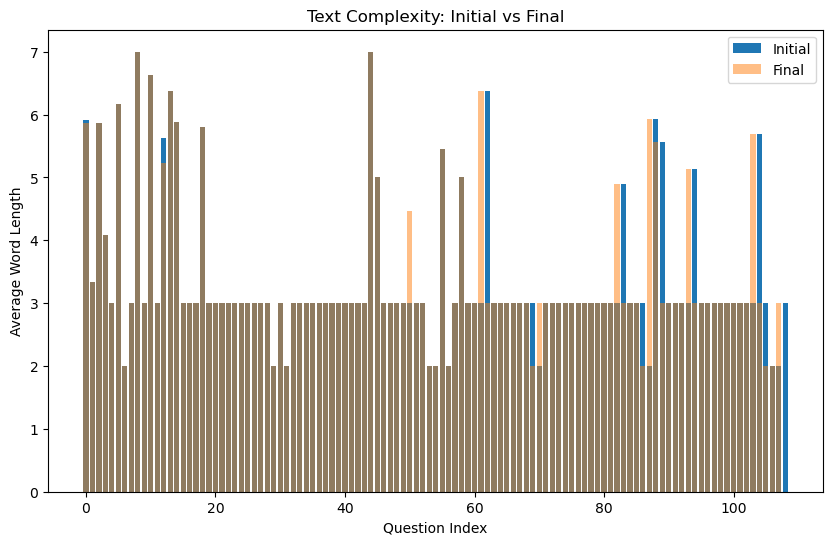

In [127]:
# Text Complexity Analysis
def text_complexity(text):
    words = text.split()
    return sum(len(word) for word in words) / len(words)

initial_df['complexity'] = initial_df['answer'].apply(text_complexity)
final_df['complexity'] = final_df['answer'].apply(text_complexity)

plt.figure(figsize=(10, 6))
plt.bar(range(len(initial_df)), initial_df['complexity'],  label='Initial')
plt.bar(range(len(final_df)), final_df['complexity'], alpha=0.5, label='Final')
plt.xlabel('Question Index')
plt.ylabel('Average Word Length')
plt.title('Text Complexity: Initial vs Final')
plt.legend()
plt.show()

In [128]:
# Named Entity Recognition (NER)
nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents]

initial_entities = extract_entities(initial_text)
final_entities = extract_entities(final_text)

print("Top 10 Named Entities in Initial Version:", Counter(initial_entities).most_common(10))
print("Top 10 Named Entities in Final Version:", Counter(final_entities).most_common(10))

Top 10 Named Entities in Initial Version: [('ClientABC', 13), ('third', 6), ('API', 6), ('GCP', 4), ('IP', 3), ('Java', 2), ('JavaScript', 2), ('AWS', 2), ('the Amazon Web Services', 2), ('Cloud Platform', 2)]
Top 10 Named Entities in Final Version: [('ClientABC', 14), ('third', 6), ('API', 5), ('GCP', 4), ('IP', 3), ('Java', 2), ('JavaScript', 2), ('AWS', 2), ('the Amazon Web Services', 2), ('Cloud Platform', 2)]


In [129]:
# Jaccard Similarity
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

jaccard_sim = jaccard_similarity(initial_words, final_words)
print(f"Jaccard Similarity between versions: {jaccard_sim:.4f}")

Jaccard Similarity between versions: 0.9913


In [130]:
# Semantic Analysis using Word2Vec
initial_model = Word2Vec([initial_words], vector_size=100, window=5, min_count=1, workers=4)
final_model = Word2Vec([final_words], vector_size=100, window=5, min_count=1, workers=4)

def get_document_vector(model, words):
    return np.mean([model.wv[word] for word in words if word in model.wv], axis=0)

initial_vector = get_document_vector(initial_model, initial_words)
final_vector = get_document_vector(final_model, final_words)

semantic_similarity = cosine_similarity([initial_vector], [final_vector])[0][0]
print(f"Semantic Similarity (Word2Vec): {semantic_similarity:.4f}")

Semantic Similarity (Word2Vec): 0.9891


In [131]:
# Feature Engineering
nlp = spacy.load("en_core_web_sm")

def extract_features(text):
    doc = nlp(text)
    return {
        'num_words': len(doc),
        'num_sentences': len(list(doc.sents)),
        'num_entities': len(doc.ents),
        'num_noun_chunks': len(list(doc.noun_chunks)),
        'avg_token_length': np.mean([len(token.text) for token in doc]),
        'num_stop_words': len([token for token in doc if token.is_stop]),
        'num_punctuations': len([token for token in doc if token.is_punct]),
        'num_verbs': len([token for token in doc if token.pos_ == 'VERB']),
        'num_nouns': len([token for token in doc if token.pos_ == 'NOUN']),
        'num_adjectives': len([token for token in doc if token.pos_ == 'ADJ']),
    }

initial_features = extract_features(initial_text)
final_features = extract_features(final_text)

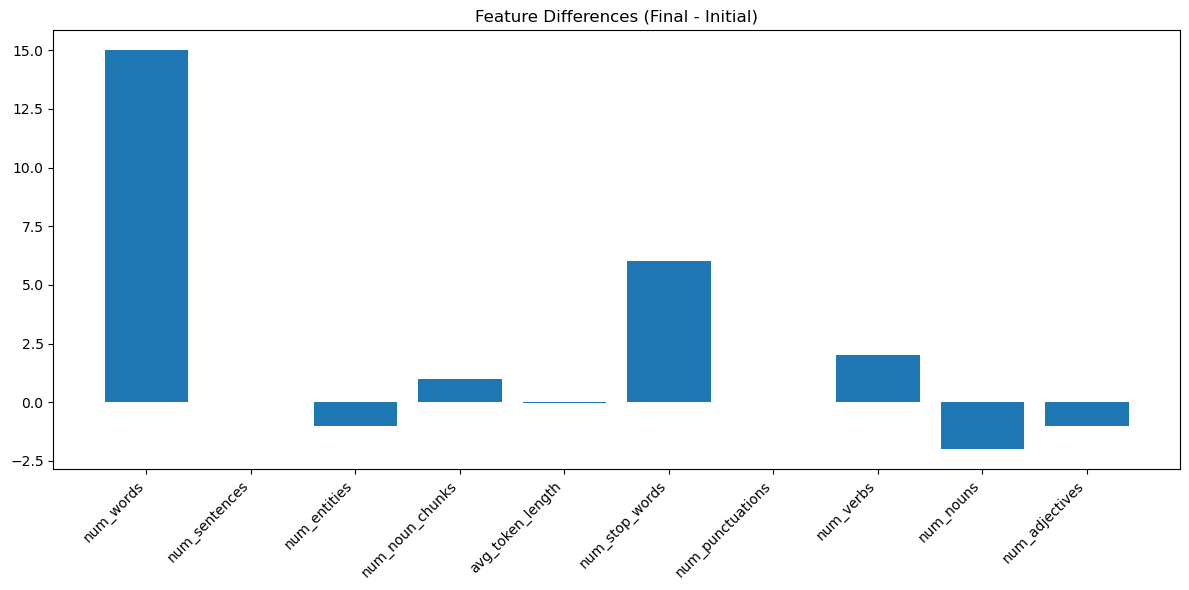

In [132]:
# Feature Analysis
feature_diff = {k: final_features[k] - initial_features[k] for k in initial_features}

plt.figure(figsize=(12, 6))
plt.bar(feature_diff.keys(), feature_diff.values())
plt.title('Feature Differences (Final - Initial)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [133]:
# Topic Modeling using LDA
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform([initial_text, final_text])

lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_output = lda_model.fit_transform(tfidf_matrix)

def print_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

print("\nInitial Version Topics:")
print_topics(lda_model, tfidf_vectorizer.get_feature_names_out(), 10)
print("\nFinal Version Topics:")
print_topics(lda_model, tfidf_vectorizer.get_feature_names_out(), 10)



Initial Version Topics:
Topic 1: least, third, an, at, our, log, api, that, frameworks, policy
Topic 2: yes, you, and, do, to, the, your, is, for, data
Topic 3: least, third, an, at, our, log, api, that, frameworks, policy
Topic 4: least, third, an, at, our, log, api, that, frameworks, policy
Topic 5: least, third, an, at, our, log, api, that, frameworks, policy

Final Version Topics:
Topic 1: least, third, an, at, our, log, api, that, frameworks, policy
Topic 2: yes, you, and, do, to, the, your, is, for, data
Topic 3: least, third, an, at, our, log, api, that, frameworks, policy
Topic 4: least, third, an, at, our, log, api, that, frameworks, policy
Topic 5: least, third, an, at, our, log, api, that, frameworks, policy


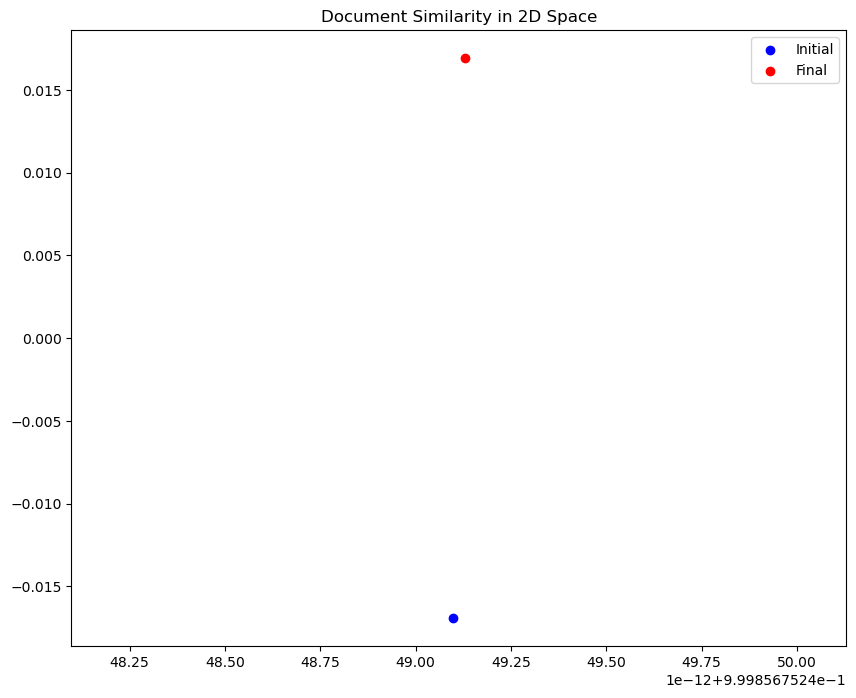

In [134]:
# Dimensionality Reduction for Visualization
svd = TruncatedSVD(n_components=2, random_state=42)
svd_output = svd.fit_transform(tfidf_matrix)

plt.figure(figsize=(10, 8))
plt.scatter(svd_output[0, 0], svd_output[0, 1], c='blue', label='Initial')
plt.scatter(svd_output[1, 0], svd_output[1, 1], c='red', label='Final')
plt.title('Document Similarity in 2D Space')
plt.legend()
plt.show()

In [135]:
# Semantic Similarities
# Load a pre-trained sentence transformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Preprocess function
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    return ' '.join([word for word in tokens if word.isalnum() and word not in stop_words])

# Function to compute semantic similarity
def semantic_similarity(text1, text2):
    embeddings = model.encode([text1, text2])
    return cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]

# Compute similarities
similarities = []
for i in range(len(final_df)):
    final_q = preprocess(final_df.iloc[i, 2])
    final_a = preprocess(final_df.iloc[i, 3])
    
for i in range(len(initial_df)):
    initial_q = preprocess(initial_df.iloc[i, 2])
    initial_a = preprocess(initial_df.iloc[i, 3])
    
similarities.append({
    'Question Similarity': semantic_similarity(initial_q, final_q),
    'Answer Similarity': semantic_similarity(initial_a, final_a),
    'Initial Q-A Similarity': semantic_similarity(initial_q, initial_a),
    'Final Q-A Similarity': semantic_similarity(final_q, final_a)
})

similarities_df = pd.DataFrame(similarities)

c:\Users\LEGION\miniconda3\envs\securitypal_task2\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


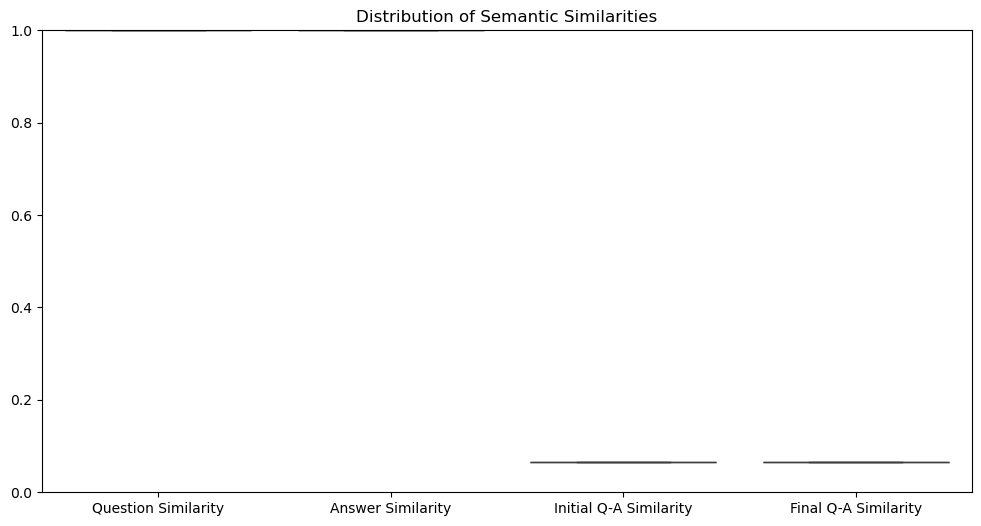

In [136]:
# Plotting boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=similarities_df)
plt.title('Distribution of Semantic Similarities')
plt.ylim(0, 1)
plt.show()


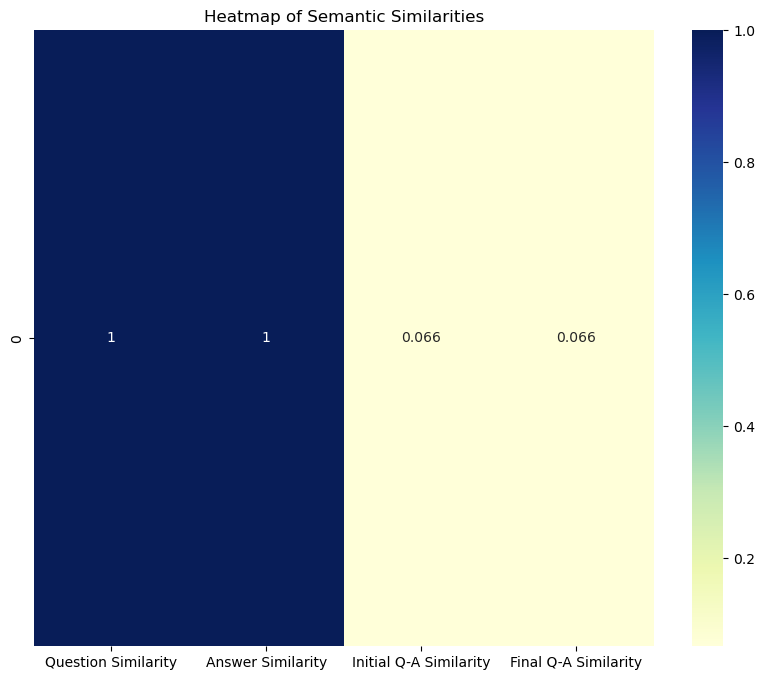

In [137]:
# Heatmap of similarities
plt.figure(figsize=(10, 8))
sns.heatmap(similarities_df, annot=True, cmap='YlGnBu')
plt.title('Heatmap of Semantic Similarities')
plt.show()

In [138]:
len(final_df)

108

C:\Users\LEGION\AppData\Local\Temp\ipykernel_39948\2288529320.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_initial_df['flesch_reading_ease'] = reduced_initial_df['answer'].apply(flesch_reading_ease)
C:\Users\LEGION\AppData\Local\Temp\ipykernel_39948\2288529320.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_initial_df['flesch_kincaid_grade'] = reduced_initial_df['answer'].apply(flesch_kincaid_grade)


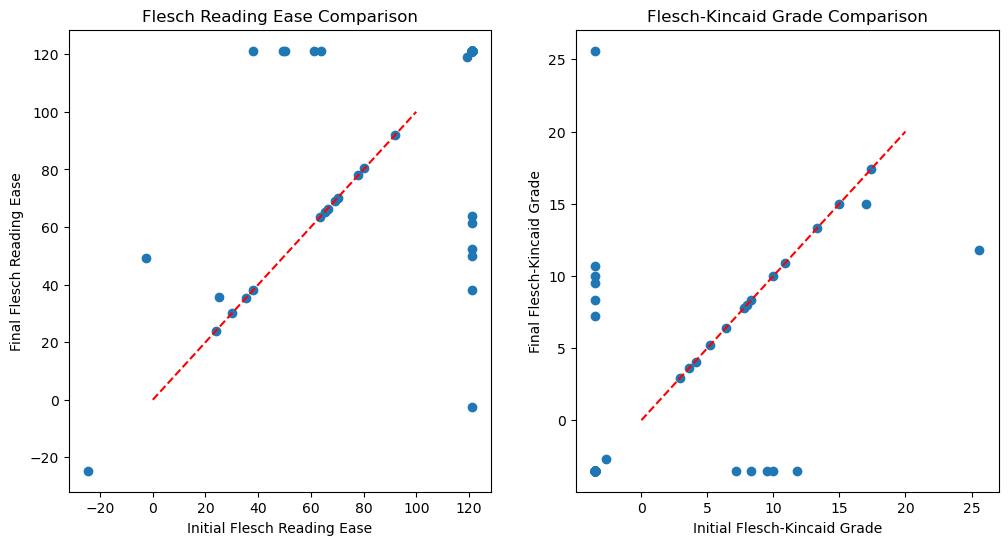

In [139]:
# The size of initial and final df is 108 and 109 respectively which does not match
# Hence 1 row is removed from initial_df to match the size of final_df
reduced_initial_df = initial_df[0:108]
reduced_initial_df['flesch_reading_ease'] = reduced_initial_df['answer'].apply(flesch_reading_ease)
final_df['flesch_reading_ease'] = final_df['answer'].apply(flesch_reading_ease)
reduced_initial_df['flesch_kincaid_grade'] = reduced_initial_df['answer'].apply(flesch_kincaid_grade)
final_df['flesch_kincaid_grade'] = final_df['answer'].apply(flesch_kincaid_grade)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(reduced_initial_df['flesch_reading_ease'], final_df['flesch_reading_ease'])
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Initial Flesch Reading Ease')
plt.ylabel('Final Flesch Reading Ease')
plt.title('Flesch Reading Ease Comparison')

plt.subplot(1, 2, 2)
plt.scatter(reduced_initial_df['flesch_kincaid_grade'], final_df['flesch_kincaid_grade'])
plt.plot([0, 20], [0, 20], 'r--')
plt.xlabel('Initial Flesch-Kincaid Grade')
plt.ylabel('Final Flesch-Kincaid Grade')
plt.title('Flesch-Kincaid Grade Comparison')

plt.show()

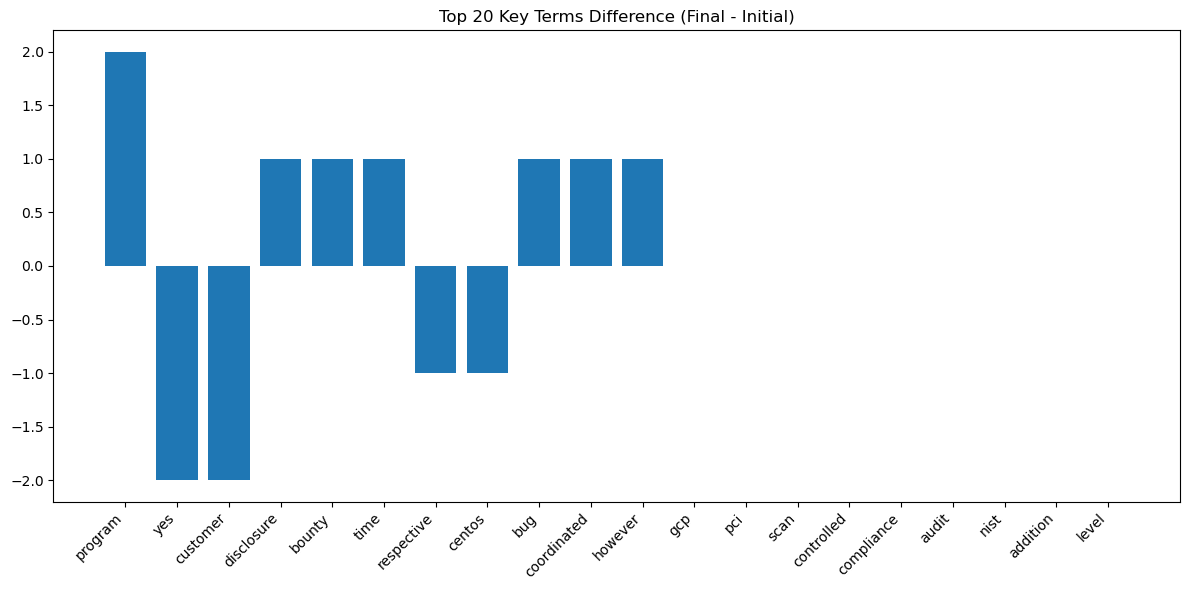

In [140]:
# Key Terms Analysis
initial_text = ' '.join(initial_df['answer'])
final_text = ' '.join(final_df['answer'])

initial_words = preprocess_text(initial_text)
final_words = preprocess_text(final_text)

initial_freq = Counter(initial_words)
final_freq = Counter(final_words)

def get_key_terms_diff(freq1, freq2, n=20):
    all_words = set(freq1.keys()) | set(freq2.keys())
    return sorted([(word, freq2.get(word, 0) - freq1.get(word, 0)) for word in all_words], 
                  key=lambda x: abs(x[1]), reverse=True)[:n]

key_terms_diff = get_key_terms_diff(initial_freq, final_freq)

plt.figure(figsize=(12, 6))
plt.bar([x[0] for x in key_terms_diff], [x[1] for x in key_terms_diff])
plt.title('Top 20 Key Terms Difference (Final - Initial)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\LEGION\AppData\Local\Temp\ipykernel_39948\1761223764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_initial_df['answer_length'] = reduced_initial_df['answer'].str.len()


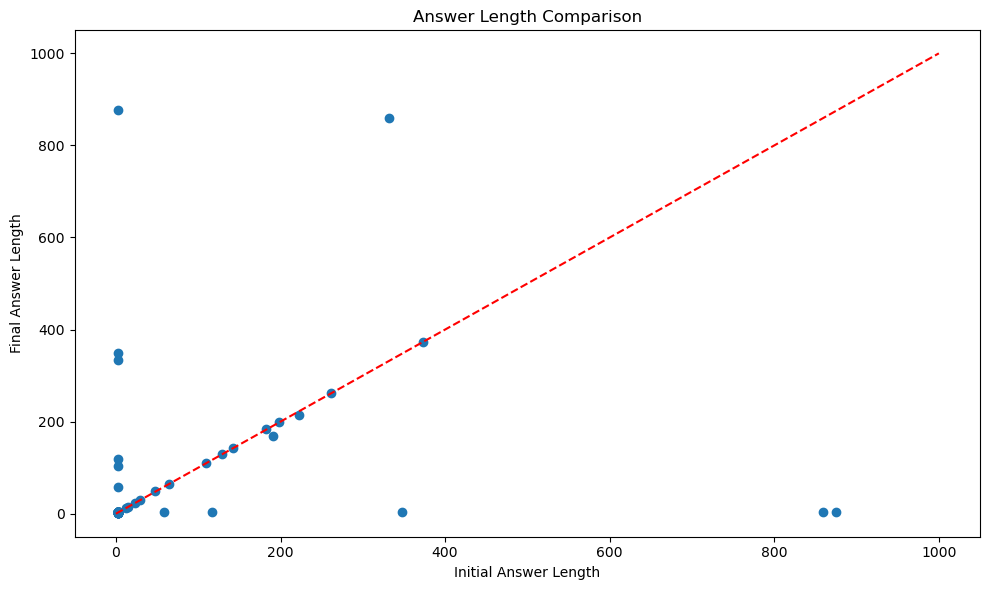

In [142]:
# Answer Length Analysis
reduced_initial_df['answer_length'] = reduced_initial_df['answer'].str.len()
final_df['answer_length'] = final_df['answer'].str.len()

plt.figure(figsize=(10, 6))
plt.scatter(reduced_initial_df['answer_length'], final_df['answer_length'])
plt.plot([0, 1000], [0, 1000], 'r--')
plt.xlabel('Initial Answer Length')
plt.ylabel('Final Answer Length')
plt.title('Answer Length Comparison')
plt.tight_layout()
plt.show()

C:\Users\LEGION\AppData\Local\Temp\ipykernel_39948\3567134825.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_initial_df['noun_phrases'] = reduced_initial_df['answer'].apply(get_noun_phrases)


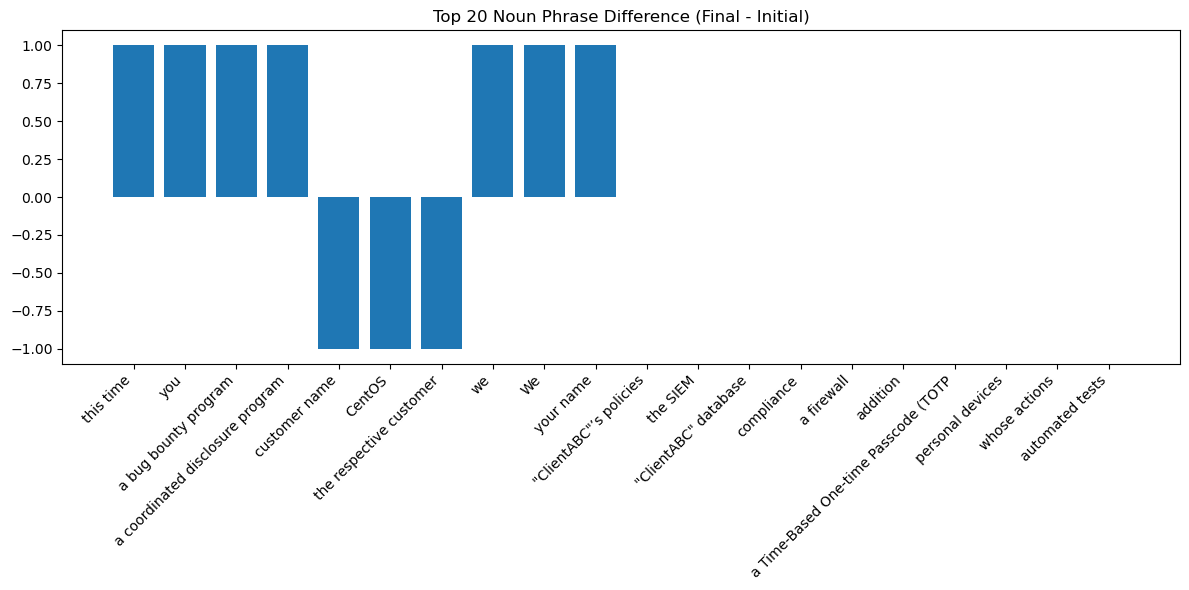

In [143]:
# Topic Coherence
nlp = spacy.load("en_core_web_sm")

def get_noun_phrases(text):
    doc = nlp(text)
    return [chunk.text for chunk in doc.noun_chunks]

reduced_initial_df['noun_phrases'] = reduced_initial_df['answer'].apply(get_noun_phrases)
final_df['noun_phrases'] = final_df['answer'].apply(get_noun_phrases)

initial_phrases = [phrase for phrases in reduced_initial_df['noun_phrases'] for phrase in phrases]
final_phrases = [phrase for phrases in final_df['noun_phrases'] for phrase in phrases]

initial_phrase_freq = Counter(initial_phrases)
final_phrase_freq = Counter(final_phrases)

phrase_diff = get_key_terms_diff(initial_phrase_freq, final_phrase_freq)

plt.figure(figsize=(12, 6))
plt.bar([x[0] for x in phrase_diff], [x[1] for x in phrase_diff])
plt.title('Top 20 Noun Phrase Difference (Final - Initial)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


C:\Users\LEGION\AppData\Local\Temp\ipykernel_39948\3603711863.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


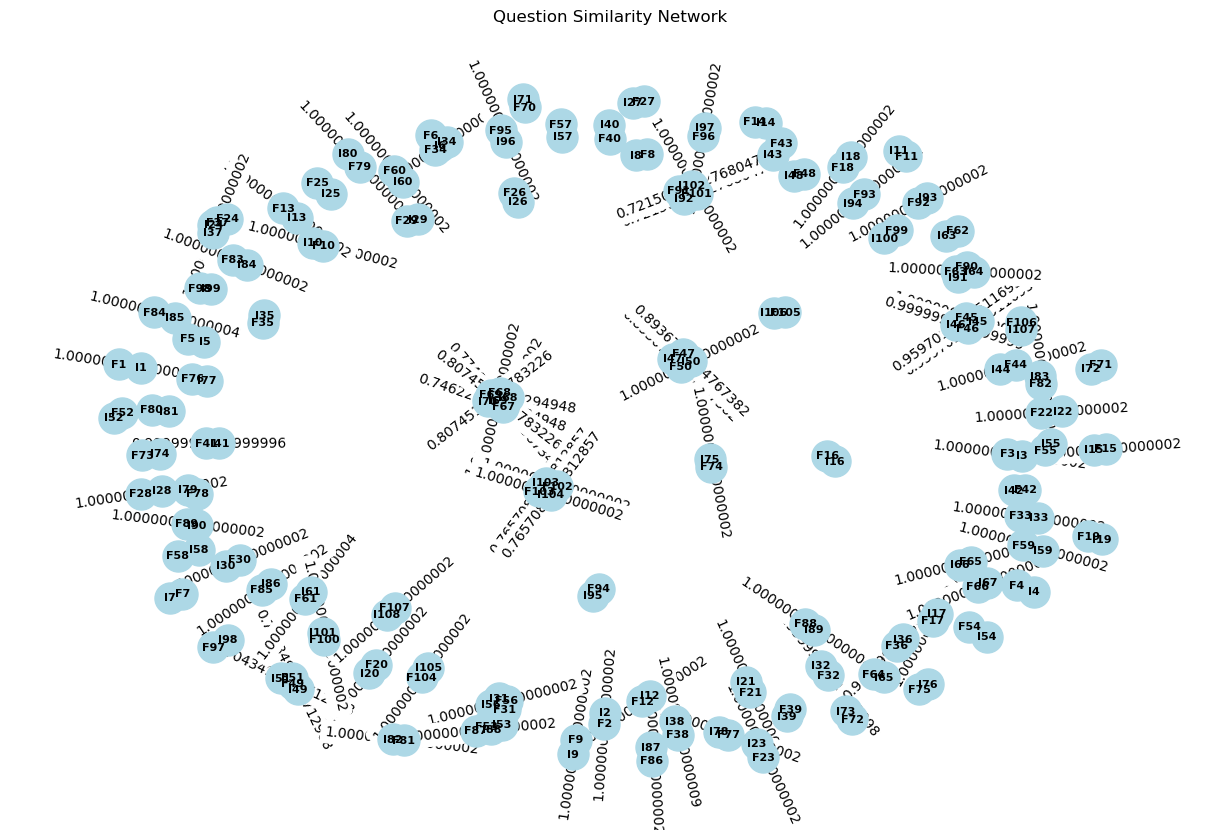

In [152]:
#  Question Similarity Network
tfidf_vectorizer = TfidfVectorizer()
all_questions = pd.concat([reduced_initial_df['question'], final_df['question']])
tfidf_matrix = tfidf_vectorizer.fit_transform(all_questions)
similarity_matrix = cosine_similarity(tfidf_matrix)

G = nx.Graph()
for i in range(len(reduced_initial_df)):
    for j in range(len(reduced_initial_df), len(reduced_initial_df) + len(final_df)):
        if similarity_matrix[i, j] > 0.5:  # Adjust threshold as needed
            G.add_edge(f'I{i+1}', f'F{j-len(reduced_initial_df)+1}', weight=similarity_matrix[i, j])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=500, font_size=8, font_weight='bold')
edge_weights = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)
plt.title('Question Similarity Network')
plt.tight_layout()
plt.show()

In [160]:
# Statistical Tests
t_stat, p_value = ttest_rel(reduced_initial_df['flesch_reading_ease'], final_df['flesch_reading_ease'])
print(f"Paired t-test for Flesch Reading Ease: t-statistic = {t_stat}, p-value = {p_value}")

t_stat, p_value = ttest_rel(reduced_initial_df['flesch_kincaid_grade'], final_df['flesch_kincaid_grade'])
print(f"Paired t-test for Flesch-Kincaid Grade: t-statistic = {t_stat}, p-value = {p_value}")

t_stat, p_value = ttest_rel(reduced_initial_df['answer_length'], final_df['answer_length'])
print(f"Paired t-test for Answer Length: t-statistic = {t_stat}, p-value = {p_value}")


Paired t-test for Flesch Reading Ease: t-statistic = 0.22639274067915008, p-value = 0.821327894143768
Paired t-test for Flesch-Kincaid Grade: t-statistic = -0.23240484303541026, p-value = 0.8166675280185347
Paired t-test for Answer Length: t-statistic = -0.04889242774087215, p-value = 0.9610961702221656
